## Access Diver Mobile Macroinvertebrate Abundance QC (Parquet)
This Jupyter notebook demonstrates how to access and plot diver_mobile_macroinvertebrate_abundance_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/48cf3cb9-caa9-4633-9baa-8bba3c4d904a).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/diver_mobile_macroinvertebrate_abundance_qc.ipynb).


In [1]:
dataset_name = "diver_mobile_macroinvertebrate_abundance_qc"

## Install/Update packages and Load common functions

In [ ]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

In [2]:
from DataQuery import GetAodn

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:3217: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 66.4 ms, sys: 9.85 ms, total: 76.2 ms
Wall time: 8.64 s


In [4]:
aodn_dataset.dataset.partitioning.schema

timestamp: int32
polygon: string

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('timestamp')
print(list(unique_partition_value)[0:2])  # showing a subset only

['1640995200', '1230768000']
CPU times: user 4.65 ms, sys: 4.69 ms, total: 9.33 ms
Wall time: 6.86 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


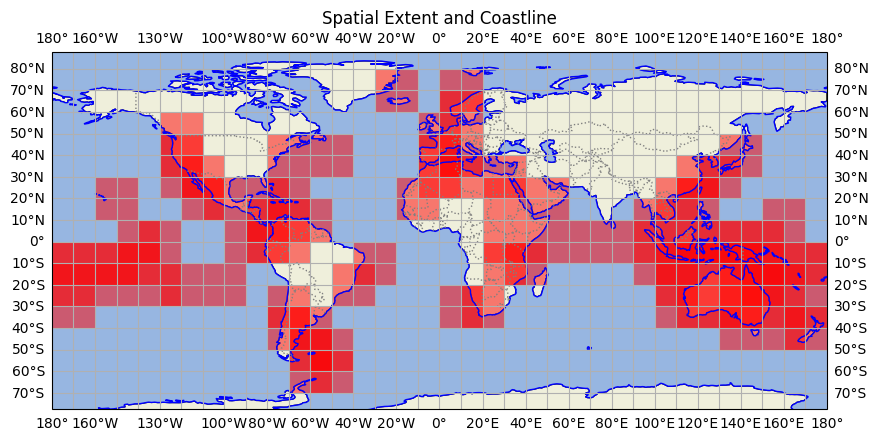

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 142 ms, sys: 24.8 ms, total: 167 ms
Wall time: 858 ms


(Timestamp('1992-03-10 00:00:00'), Timestamp('2025-09-15 15:00:00'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-11-10 12:42:04,503 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/diver_mobile_macroinvertebrate_abundance_qc.parquet


{'survey_id': {'type': 'int32'},
 'country': {'type': 'string'},
 'area': {'type': 'string'},
 'ecoregion': {'type': 'string'},
 'realm': {'type': 'string'},
 'location': {'type': 'string'},
 'site_code': {'type': 'string'},
 'site_name': {'type': 'string'},
 'latitude': {'type': 'float32'},
 'longitude': {'type': 'float32'},
 'survey_date': {'type': 'string'},
 'depth': {'type': 'float32'},
 'program': {'type': 'string'},
 'visibility': {'type': 'string'},
 'hour': {'type': 'string'},
 'survey_latitude': {'type': 'string'},
 'survey_longitude': {'type': 'string'},
 'method': {'type': 'int32'},
 'block': {'type': 'int32'},
 'phylum': {'type': 'string'},
 'class_': {'type': 'string'},
 'order': {'type': 'string'},
 'family': {'type': 'string'},
 'species_name': {'type': 'string'},
 'reporting_name': {'type': 'string'},
 'size_class': {'type': 'float32'},
 'total': {'type': 'int32'},
 'biomass': {'type': 'string'},
 'geom': {'type': 'string'},
 'filename': {'type': 'string',
  'units': '

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2015-12-01', 
                           date_end='2019-01-01',
                           lat_min=-34, 
                           lat_max=-31, 
                           lon_min=151, 
                           lon_max=153,
                           lat_varname="latitude",
                           lon_varname="longitude",
                           )

df.info()

2025-11-10 12:42:05,141 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/diver_mobile_macroinvertebrate_abundance_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   survey_id         3720 non-null   int32         
 1   country           3720 non-null   object        
 2   area              3720 non-null   object        
 3   ecoregion         3720 non-null   object        
 4   realm             3720 non-null   object        
 5   location          3720 non-null   object        
 6   site_code         3720 non-null   object        
 7   site_name         3720 non-null   object        
 8   latitude          3720 non-null   float32       
 9   longitude         3720 non-null   float32       
 10  survey_date       3720 non-null   object        
 11  depth             3720 non-null   float32       
 12  program           3720 non-null   object        
 13  visibility        3703 non-null   object        
 14  hour              3671 n

In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_48cf3cb9-caa9-4633-9baa-8bba3c4d904a_diver_mobile_macroinvertebrate_abundance_qc_data-hash_0afce125.csv.zip

In [13]:
import folium

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=6)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2 + row['total']/5,  # scale by total
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['site_name']}<br>{row['species_name']}<br>Total: {row['total']}"
    ).add_to(m)

m
